In [1]:
"""
The attached file contains a Salinas hyperspectral image.

Reduce its dimensions using PCA.
Perform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.
"""

'\nThe attached file contains a Salinas hyperspectral image.\n\nReduce its dimensions using PCA.\nPerform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.\n'

Number of clusters: 17


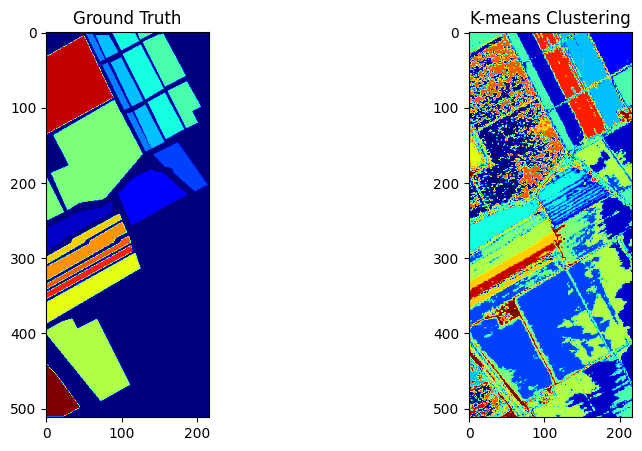

Clustering accuracy: 0.02


In [38]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 216  # Number of principal components
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_reshaped)
data_pca = data_reshaped
# Perform k-means clustering
n_clusters = len(np.unique(ground_truth))  # Number of clusters (excluding background)
print(f'Number of clusters: {n_clusters}')
kmeans = KMeans(n_clusters=n_clusters, max_iter=10000)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat > -1 # Exclude background
accuracy = accuracy_score(ground_truth_flat[mask], clusters_flat[mask])
print(f'Clustering accuracy: {accuracy:.2f}')

Salinas şekli: (512, 217, 224)
Salinas GT şekli: (512, 217)
PCA ile azaltılmış veri şekli: (111104, 3)


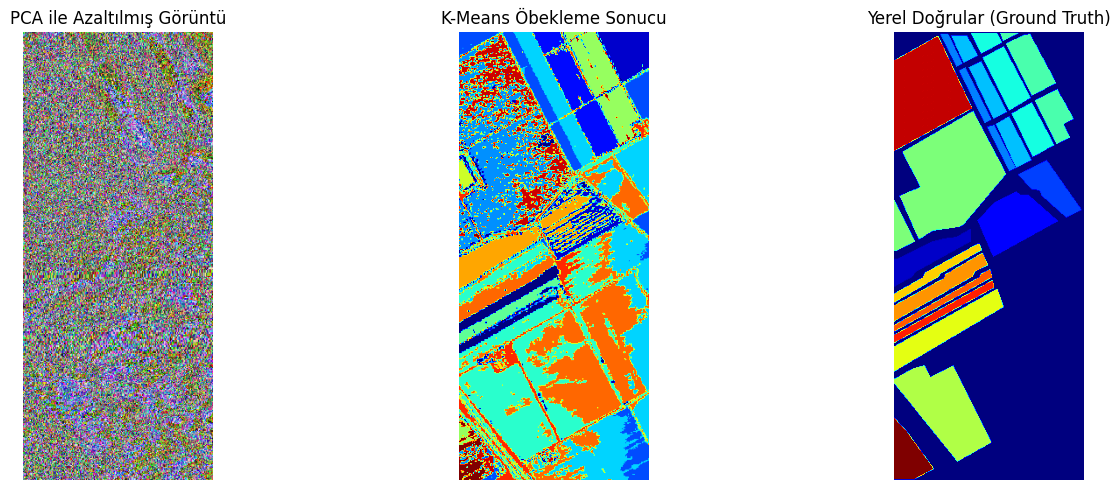

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.io import loadmat

# Salinas ve Salinas GT dosyalarını yükle

data = loadmat('salinas.mat')
salinas = data['salinas']

data_gt = loadmat('salinas_gt.mat')
salinas_gt = data_gt['salinas_gt']

# Veri boyutlarını kontrol et
print("Salinas şekli:", salinas.shape)
print("Salinas GT şekli:", salinas_gt.shape)
# Hiperspektral görüntüyü 2D formata dönüştür
rows, cols, bands = salinas.shape
salinas_reshaped = salinas.reshape(rows * cols, bands)

# PCA uygulayarak boyutları azalt
pca = PCA(n_components=3)  # İlk 3 bileşeni koruyalım
salinas_pca = pca.fit_transform(salinas_reshaped)

# PCA sonucu veriyi eski formata döndür
salinas_pca_image = salinas_pca.reshape(rows, cols, 3)
print("PCA ile azaltılmış veri şekli:", salinas_pca.shape)
# K-Means ile öbekleme
num_clusters = len(np.unique(salinas_gt)) - 1  # GT'deki sınıf sayısını al
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(salinas_pca)

# Öbek sonuçlarını görüntü formatına döndür
kmeans_image = kmeans_labels.reshape(rows, cols)
# Sonuçları görselleştir
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(salinas_pca_image.astype(np.uint8))
axes[0].set_title("PCA ile Azaltılmış Görüntü")
axes[0].axis('off')

axes[1].imshow(kmeans_image, cmap='jet')
axes[1].set_title("K-Means Öbekleme Sonucu")
axes[1].axis('off')

axes[2].imshow(salinas_gt, cmap='jet')
axes[2].set_title("Yerel Doğrular (Ground Truth)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Salinas boyutları: (512, 217, 224)
Salinas GT boyutları: (512, 217)
Salinas reshaped boyutları: (111104, 224)
PCA ile azaltılmış veri şekli: (111104, 10)
Adjusted Rand Index: 0.5266490556385068
Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0   15    0    0    0    0    0 1994    0    0    0    0    0
     0    0    0]
 [   0    5 2463    0    0   20    1    0 1067   11    0    0    0    0
     0  159    0]
 [   0    0    0    0  961    0    0    2    0    0  871  142    0    0
     0    0    0]
 [   0    0    0    0    0    0    0 1380    0    0   14    0    0    0
     0    0    0]
 [   3    0    0    0   26    0    0   31    0    0 2616    2    0    0
     0    0    0]
 [  86    0    0 1790    2    0    0    0    0   14    0    0    0    0
  2067    0    0]
 [   0   24    0    0    1 1430    6    0    0    0    1    0    3    0
     0 2114    0]
 [  94  218    0    4    7   13 7354    0    0   14    0    3  485 

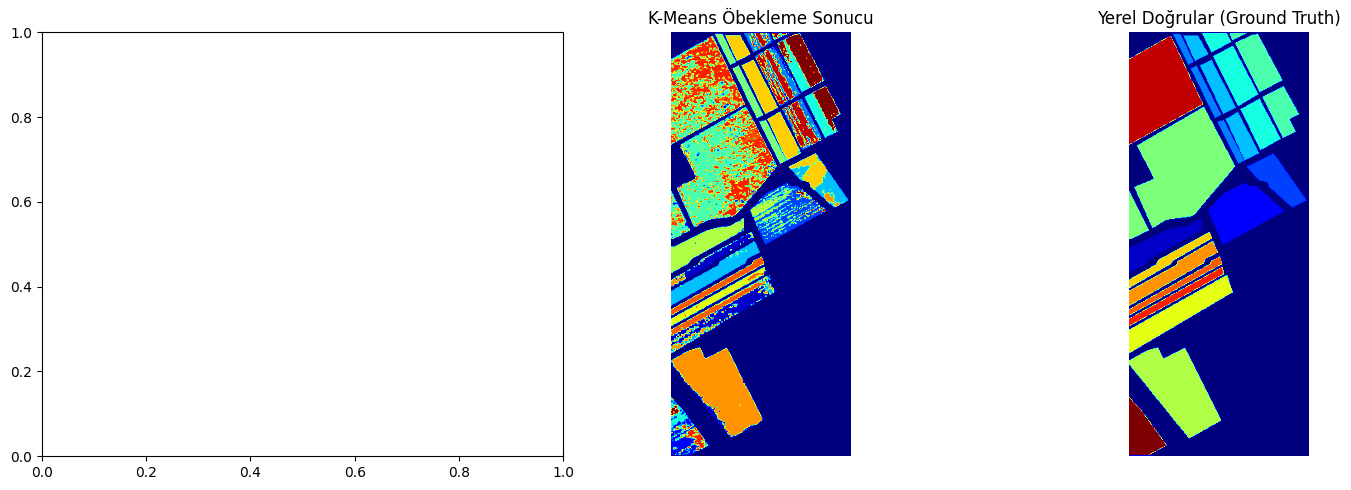

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.io import loadmat

# Veriyi yükleme
data = loadmat('salinas.mat')
salinas = data['salinas']

data_gt = loadmat('salinas_gt.mat')
salinas_gt = data_gt['salinas_gt']

# Veri boyutlarını kontrol et
rows, cols, bands = salinas.shape
print("Salinas boyutları:", salinas.shape)
print("Salinas GT boyutları:", salinas_gt.shape)

# Hiperspektral görüntüyü 2D formata dönüştür
salinas_reshaped = salinas.reshape(rows * cols, bands)
print("Salinas reshaped boyutları:", salinas_reshaped.shape)
# PCA ile boyut indirgeme
component_number = 10

pca = PCA(n_components=component_number)  # İlk 3 bileşen
salinas_pca = pca.fit_transform(salinas_reshaped)
#print the shapw
print("PCA ile azaltılmış veri şekli:", salinas_pca.shape)

# PCA sonucu veriyi eski formata döndür
salinas_pca_image = salinas_pca.reshape(rows, cols, component_number)

# Geçerli alanları seç
mask = salinas_gt > 0  # GT'deki geçerli alanları seç
salinas_valid = salinas_pca[mask.flatten()]  # PCA sonrası geçerli alanlar

# K-Means öbekleme
num_clusters = len(np.unique(salinas_gt)) - 1  # Ground truth'daki sınıf sayısı
kmeans = KMeans(n_clusters=num_clusters, random_state=42, init='k-means++', n_init=10)
labels = kmeans.fit_predict(salinas_valid)

# Öbek sonuçlarını görüntü formatına dönüştür
kmeans_image = np.zeros_like(salinas_gt)
kmeans_image[mask] = labels + 1  # 1 tabanlı hale getir

# Performans değerlendirme
true_labels = salinas_gt[mask]
print("Adjusted Rand Index:", adjusted_rand_score(true_labels, labels))
print("Confusion Matrix:\n", confusion_matrix(true_labels, labels))

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PCA Görselleştirme
#axes[0].imshow((salinas_pca_image - salinas_pca_image.min()) / 
#               (salinas_pca_image.max() - salinas_pca_image.min()))
#axes[0].set_title("PCA ile Azaltılmış Görüntü")
#axes[0].axis('off')

# K-Means Görselleştirme
axes[1].imshow(kmeans_image, cmap='jet')
axes[1].set_title("K-Means Öbekleme Sonucu")
axes[1].axis('off')

# Yerel Doğrular (Ground Truth)
axes[2].imshow(salinas_gt, cmap='jet')
axes[2].set_title("Yerel Doğrular (Ground Truth)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
ground_truth_flat

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Number of clusters: 17


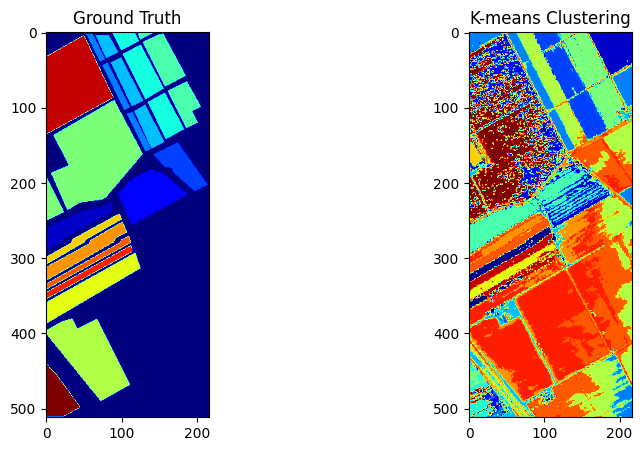

Clustering accuracy: 0.39


In [41]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = min(1000, n_bands)  # Ensure n_components is not greater than n_bands
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_reshaped)

# Perform k-means clustering
n_clusters = len(np.unique(ground_truth))  # Number of clusters (excluding background)
print(f'Number of clusters: {n_clusters}')
kmeans = KMeans(n_clusters=n_clusters, max_iter=1000000, random_state=42)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters

# Re-label clusters to match ground truth labels (optional, depends on your dataset)
# This is a heuristic for matching clusters to ground truth classes
mode, _ = stats.mode(clusters_flat)
clusters_flat = np.where(clusters_flat == mode, 1, 0)  # Adjust depending on ground_truth

# Compute accuracy
accuracy = accuracy_score(ground_truth_flat, clusters_flat)
print(f'Clustering accuracy: {accuracy:.2f}')


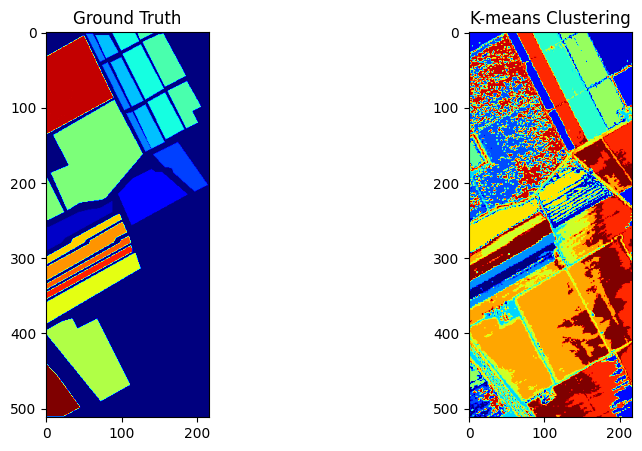

Clustering accuracy (Hungarian-aligned): 0.67
ARI: 0.52, NMI: 0.72


In [39]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 216  # Choose number of principal components
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_reshaped)

# Perform k-means clustering
n_clusters = len(np.unique(ground_truth)) - 1  # Exclude background
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat > 0  # Exclude background

# Adjust cluster labels using Hungarian algorithm
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(ground_truth_flat[mask], clusters_flat[mask])
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
accuracy = conf_matrix[row_ind, col_ind].sum() / mask.sum()

# Evaluate clustering with ARI and NMI
ari = adjusted_rand_score(ground_truth_flat[mask], clusters_flat[mask])
nmi = normalized_mutual_info_score(ground_truth_flat[mask], clusters_flat[mask])

print(f'Clustering accuracy (Hungarian-aligned): {accuracy:.2f}')
print(f'ARI: {ari:.2f}, NMI: {nmi:.2f}')


In [31]:
print(n_clusters)

16


In [32]:
print(np.max(ground_truth))

16


In [25]:
print(clusters)

[4 4 4 ... 4 4 4]


In [30]:
print(ground_truth)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [16 16 16 ...  0  0  0]
 [16 16 16 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [26]:
print(ground_truth_flat)

[0 0 0 ... 0 0 0]


In [16]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']

print(data)


[[[290 381 585 ...  11  17  10]
  [290 381 519 ...  11  15  16]
  [290 381 585 ...  11  11  12]
  ...
  [373 482 594 ...   4   0   4]
  [373 482 659 ...   0   5   0]
  [305 393 655 ...   1  -3  -2]]

 [[379 400 600 ...  11  15   8]
  [308 400 535 ...  15  13   8]
  [379 483 535 ...   5  15   8]
  ...
  [376 477 590 ...   0  -5   1]
  [376 477 590 ...   0  13   1]
  [305 393 655 ...   1  -3  -2]]

 [[369 495 604 ...   9  17   4]
  [298 411 604 ...   5  13   6]
  [298 411 670 ...   7  13  10]
  ...
  [447 468 664 ...   7   0   1]
  [305 468 664 ...   7   2   1]
  [447 384 664 ...   1   4   3]]

 ...

 [[379 383 540 ...   5   9   4]
  [308 383 540 ...   5   5   2]
  [379 383 540 ...  -2   7   4]
  ...
  [367 387 661 ...  17  23  12]
  [367 470 661 ...  15  23  12]
  [438 470 596 ...  13  27  16]]

 [[314 479 604 ...   5   0   4]
  [314 396 539 ...   3   2  -1]
  [385 396 539 ...   1   0   6]
  ...
  [367 387 661 ...  17  23  12]
  [367 470 661 ...  15  23  12]
  [376 489 674 ...  15  23  

In [17]:
print(data.shape)

(512, 217, 224)


In [18]:
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']


In [19]:
print(ground_truth.shape)

(512, 217)
